In [213]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import cv2
import pandas as pd
import ntpath
import random
import os

In [214]:
#display first 5 rows of data from csv
datadir = 'IMG'
columns= ('center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed')
data = pd.read_csv(('driving_log.csv'), names=columns)
pd.set_option('display.max_colwidth', None)

In [215]:
#clear path from jpg files

def path_leaf(path):
    head, tail=ntpath.split(path)
    return tail

data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2022_10_12_13_21_10_965.jpg,left_2022_10_12_13_21_10_965.jpg,right_2022_10_12_13_21_10_965.jpg,0.0,0.0,0.0,0.000078
1,center_2022_10_12_13_21_11_066.jpg,left_2022_10_12_13_21_11_066.jpg,right_2022_10_12_13_21_11_066.jpg,0.0,0.0,0.0,0.000078
2,center_2022_10_12_13_21_11_167.jpg,left_2022_10_12_13_21_11_167.jpg,right_2022_10_12_13_21_11_167.jpg,0.0,0.0,0.0,0.000078
3,center_2022_10_12_13_21_11_270.jpg,left_2022_10_12_13_21_11_270.jpg,right_2022_10_12_13_21_11_270.jpg,0.0,0.0,0.0,0.000079
4,center_2022_10_12_13_21_11_371.jpg,left_2022_10_12_13_21_11_371.jpg,right_2022_10_12_13_21_11_371.jpg,0.0,0.0,0.0,0.000079


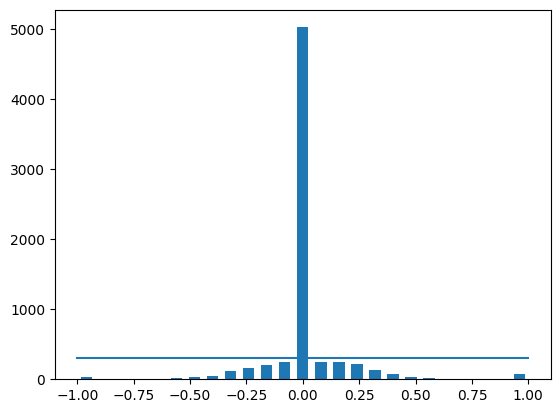

In [216]:
#draw histogram to show distribution of steering angles and select sample size per bin

num_bins = 25
samples_per_bin = 300
hist, bins =np.histogram(data['steering'], num_bins)
center = (bins[:-1] + bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

total data: 6945
removed: 4729
remaining 2216


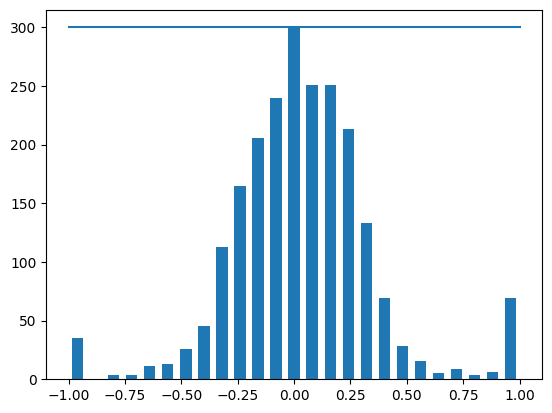

In [217]:
print('total data:', len(data))
remove_list = []
for j in range(num_bins):
    list_ = []
    for i in range(len(data['steering'])):
        if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
            list_.append(i)

    list_ = shuffle(list_)
    list_ = list_[samples_per_bin:]
    remove_list.extend(list_)

print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining', len(data))

hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [218]:

def load_img_steering(datadir,df):
    image_path=[]
    steering=[]
    for i in range(len(data)):
        indexed_data=data.iloc[i]
        center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
        image_path.append(center.strip())
        steering.append(float(indexed_data[3]))
    image_paths=np.asarray(image_path)
    steerings = np.asarray(steering)
    return image_paths, steerings

image_paths, steerings=load_img_steering('/IMG', data)
print(image_paths)


['center_2022_10_12_13_21_11_371.jpg' 'center_2022_10_12_13_21_12_789.jpg'
 'center_2022_10_12_13_21_12_991.jpg' ...
 'center_2022_10_12_13_32_51_382.jpg' 'center_2022_10_12_13_32_51_482.jpg'
 'center_2022_10_12_13_32_55_136.jpg']


In [219]:
X_train,X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print('training samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))

training samples: 1772
Valid Samples: 444


Text(0.5, 1.0, 'training set')

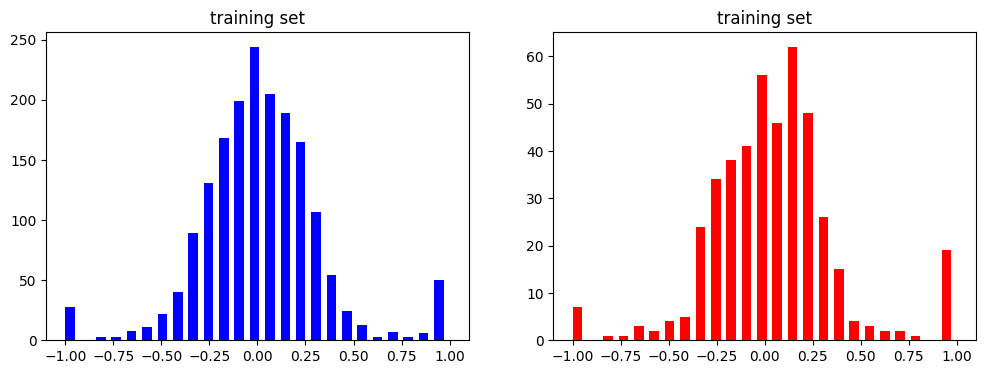

In [220]:
from turtle import width

fig, axes = plt.subplots(1, 2, figsize = (12,4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('training set')


In [221]:
def img_preprocess(img):
    img = mpimg.imread(os.path.join(r'C:\Users\Zharb\Documents\GitHub\Self-driving-car\IMG' ,img))
    img = img[60:135, :,:]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img, (3, 3), 0)
    img = cv2.resize(img, (200, 66))
    img = img/255
    return img

Text(0.5, 1.0, 'Preprocessed image')

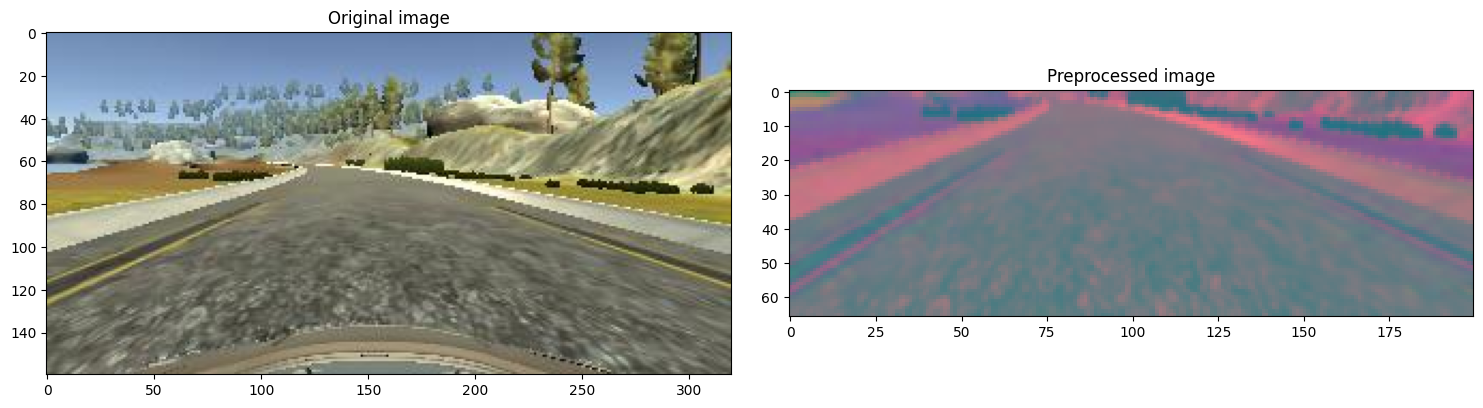

In [222]:
image = image_paths[50]
original_image = mpimg.imread(os.path.join(r'C:\Users\Zharb\Documents\GitHub\Self-driving-car\IMG' ,image))
preprocessed_image=img_preprocess(image)
fig, axs = plt.subplots(1,2, figsize=(15,10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed image')

In [223]:
X_train = np.array(list(map(img_preprocess, X_train)))
X_valid = np.array(list(map(img_preprocess, X_valid)))

(1772, 66, 200, 3)


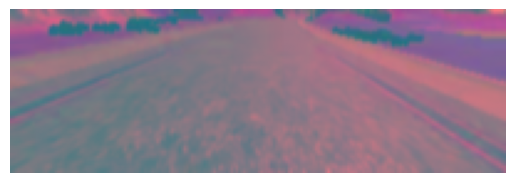

In [224]:
plt.imshow(X_train[random.randint(0,len(X_train)-1)])
plt.axis('off')
print(X_train.shape)

In [225]:
def nvidia_model():
    model = Sequential()
 
    model.add(Conv2D(24, kernel_size=(5,5), strides=(2,2), input_shape=(66,200,3),activation='elu'))
 
    model.add(Conv2D(36, kernel_size=(5,5), strides=(2,2), activation='elu'))
    model.add(Conv2D(48, kernel_size=(5,5), strides=(2,2), activation='elu'))
    model.add(Conv2D(64, kernel_size=(3,3), activation='elu'))
    model.add(Conv2D(64, kernel_size=(3,3), activation='elu'))
    model.add(Dropout(0.5))
 
 
    model.add(Flatten())
    model.add(Dense(100, activation='elu'))
    model.add(Dropout(0.5))
 
 
    model.add(Dense(50, activation='elu'))
    model.add(Dropout(0.5))

    model.add(Dense(10, activation ='elu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(1))
 
 
    optimizer= Adam(lr=1e-3)
    model.compile(loss='mse', optimizer=optimizer)
 
    return model

In [226]:
model = nvidia_model()
print(model.summary())

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_35 (Conv2D)          (None, 31, 98, 24)        1824      
                                                                 
 conv2d_36 (Conv2D)          (None, 14, 47, 36)        21636     
                                                                 
 conv2d_37 (Conv2D)          (None, 5, 22, 48)         43248     
                                                                 
 conv2d_38 (Conv2D)          (None, 3, 20, 64)         27712     
                                                                 
 conv2d_39 (Conv2D)          (None, 1, 18, 64)         36928     
                                                                 
 dropout_14 (Dropout)        (None, 1, 18, 64)         0         
                                                                 
 flatten_7 (Flatten)         (None, 1152)            

c:\Users\Zharb\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [227]:
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid), batch_size=100, verbose=1, shuffle=1)

Epoch 1/30
18/18 [==============================] - 5s 243ms/step - loss: 1.1135 - val_loss: 0.1158
Epoch 2/30
18/18 [==============================] - 4s 212ms/step - loss: 0.2456 - val_loss: 0.1035
Epoch 3/30
18/18 [==============================] - 4s 198ms/step - loss: 0.1342 - val_loss: 0.1003
Epoch 4/30
18/18 [==============================] - 3s 189ms/step - loss: 0.1097 - val_loss: 0.0963
Epoch 5/30
18/18 [==============================] - 3s 191ms/step - loss: 0.1108 - val_loss: 0.0945
Epoch 6/30
18/18 [==============================] - 3s 187ms/step - loss: 0.1078 - val_loss: 0.0907
Epoch 7/30
18/18 [==============================] - 3s 185ms/step - loss: 0.1019 - val_loss: 0.0868
Epoch 8/30
18/18 [==============================] - 3s 185ms/step - loss: 0.0990 - val_loss: 0.0853
Epoch 9/30
18/18 [==============================] - 3s 186ms/step - loss: 0.0987 - val_loss: 0.0809
Epoch 10/30
18/18 [==============================] - 3s 183ms/step - loss: 0.0929 - val_loss: 0.0796

Text(0.5, 0, 'Epoch')

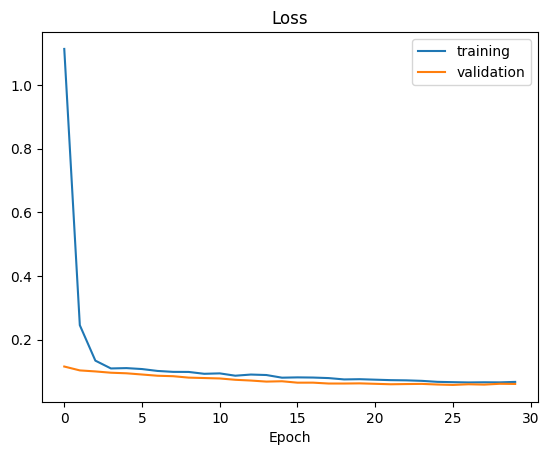

In [228]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [229]:
model.save('model.h5')